# turbpy: simulating sensible heat fluxes

### Bulk methods
**1) Standard/Anderson/Choudhury and Monteith (1988)/Jordan (1991)**

A bulk aerodynamic approximation to the Monin-Obukhov based stability correction of Webb (1970). These expressions are identical except for using the Obukhov length or the bulk Richardson number. Sets $Q_h$ to zero above a critical Richardson number. This number does not exist in nature. Identical to the standard method used previously in this study.

**2) Louis (unmodified)**

Identical to the Louis method used previously in this study

**2a) Louis (modified)**

Adjusts the b' variable to 12 from 4.7. Some very early parameter testing found that varying the b' value had almost not discernible impact on the mean bias. Based on the plots below, this seems likely to be the case again.

**2b) Louis (capped)**

Implemented the CROCUS capping. CROCUS allows multiple methods for capping conductance, I chose the one with a publication to cite. In this case, $Ri_b \>e 0.026$ which is insanely tiny level to cap at.

**3) Mahrt**

This method is "overly-turbulent". I think we are justified in dropping it (and saying we did test it) or keeping it to show that attempts at enhancing mixing by parameterizing a fixed amount of sub-grid variability is not a viable path for representing sub-grid features or counter-gradient fluxes.

### Monin-Obukhov methods

This publication describes both options 1 and 2.  
Beljaars, A. C. M., & Holtslag, A. A. M. (1991). Flux Parameterization over Land Surfaces for Atmospheric Models. Journal of Applied Meteorology. https://doi.org/10.1175/1520-0450(1991)030


**1)	Holtslag and de Bruin**

A Monin-Obukhov based stability parameterization. This was the original stability correction used in the study, but its behavior was hidden by the capping. I've modified the code to accept various cappings (described below), allowing me to easily access this stability parameterization along with others.

Note, the original citation for this method is incorrect. It was only described in Launiainen and vihma (1990). The stability correction does not appear in the originally cited paper.

This method has a critical Richardson number ($Ri_c = 1.43$)

**2)	Beljaars and Holtslag**

An adjustmebnt to the Holtslag and de Bruin method. Also a Monin-Obukhov similarity theory parameterization for the stability corrections. Makes an important assumptions that $\Psi_H \neq \Psi_M$, which required some further code refactoring.

The expression for $\Psi_H$ (stability correction for heat) comes from BH91, equation 32.

$$
\Psi_H = -(1 + \frac{2}{3}a\zeta)^(\frac{3}{2}) - b(\zeta - \frac{c}{d}) e^{-d\zeta} - \frac{bc}{d} + 1 $$

to solve for the Obukhov length iteratively, I need to find $\frac{d\Psi_h}{d\zeta}$. This is the expression I've used.

$$
\frac{d\Psi_h}{d\zeta} = (b e^{-d\zeta}(d\zeta - 1 - c) - a(\frac{2a\zeta}{3} + 1)^{\frac{1}{2}}
$$

Options 1 and 2 are mostly identical except for very stable conditions ($Ri_bulk > 1.2$). For actual testing I will use both, but will plan on only presenting BH91 since it does not include a critical Richardson number.

**4) Modified MO scheme **

Jiménez, P. A., Dudhia, J., González-Rouco, J. F., Navarro, J., Montávez, J. P., & García-Bustamante, E. (2012). A Revised Scheme for the WRF Surface Layer Formulation. Monthly Weather Review, 140(3), 898–918. https://doi.org/10.1175/MWR-D-11-00056.1

Jimenez et al. (2012) have done an incredibly thorough job documenting how the original MO scheme in WRF for the "surface layer" (which to the best of my knowledge is identical to one of the MO schemes implemented in NoahMP) leads to non-physical fluxes/behavior. They suggest an improved method, with no capping. However, this method is formulated as a "surface layer parameterization". I have some confusion on this name as they say this parameterziation only applies to the first vertical layer, but use the surface temperature to calculate Qh and stability parameters. I have no idea how this scheme relates to the land model fluxes, but it is an option for surface layer schemes section in WRF v4.0 that cannot be implemented in a land modelling framework (e.g., QNSE). My assumption is that the atmospheric science community and land modeling communities have evolved separately, leading to this confusion.

#### Log-linear methods

**5)	Log-linear/Webb/Paulson** 

These are the fifth (also called the classical theory) sixth (Webb, 1970), and seventh (Paulson 1970) names for this method I have found. The Anderson/standard method is assumed to approximate these MO stability functions. I explore this assumption a bit at the end of the notebook.

$$
\Psi_H = \Psi_M = -\alpha\zeta
$$

where alpha is assumed to be a constant with a value of 5. This leads to a critical Richardson number of ~0.2. We know this is non-physical, and likely plays a role in the substantial model ad hocery. I implement this method with $\alpha$ being a tunable parameter.

In addition, I try to mimic CLMv4.5 and NoahMPv1.1 as closely as possible as described below. Finding what code is actually implemented in these models was a bit of an odyssey. I am documenting what I have found here in full detail to help answer any future potential questions.

**5a) Webb as implemented in CLMv4.5**

Requires that the horizontal wind speed remain greater than one ($V \ge 1$) to "stop runaway cooling". 

For $0\le \zeta \le 1 $
$$\phi_h = 1 + \alpha \zeta $$

For $\zeta > 1$
$$\phi_h = \alpha + \zeta $$

The relationship between $\phi$ and $\Psi$ is

$$
\Psi = \int_{0}^{\zeta} \frac{1 - \phi(x)}{x}dx 
$$

So if we integrate to find $\Psi$ for the two cases

For $0\le \zeta \le 1 $
$$\Psi_h = -\alpha \zeta $$

For $\zeta > 1$
$$\Psi_h = (1 - \alpha)\log{\zeta} + \zeta $$

The citation that justifies these equations does not contain an expression for the stability correction or $\Psi$ (from which we can determine the stability correction). I am unsure what assumptions go into these expressions as the expressions do not converge at a value of $\zeta = 1$. This causes unstable behavior near that threshold value and leads to big jumps in the simulated $Q_h$.

It looks like the CLM people were potentially intending to use the King et al. (1996) parameterization, which looks similar:

for $\phi_h(\zeta) \le 12$

$$
\phi_h = 0.95 + 4.99\zeta
$$

however, these values do not converge either. This is also a linear funciton of stability, effectively immitating the capping method from Andreas and Jordan (2004).

**5b) Webb as implemented in NoahMP v1.1 (used in WRFv3.4)**

I would have liked to use NoahMPv1.6 (the newest version I could find), however, this code is actually stored in the HRLDAS project. The HRLDAS documentation frequently refers to the "Noah LSM". In the literature describing and comparing NoahMP, the phrase "Noah LSM" refers to the old, pre-2010 version of the model. Additionally, NoahMPv1.1 is relatively well-documented with descriptive comments and citations. A technical note, while not perfectly matching the code, is also available and useful for understanding some of the implementation.

NoahMP has four options for parameterizing turbulence. Here, I will only examine the Webb method. Other methods include substantial capping/limiting behavior (e.g., the original Chen 1997 flux parameterization). For instance, the NoahMP includes a Paulson scheme, with an identical stability correction to the Webb scheme, but with adjustments to $u*$, $z_0$, and additional capping of certain values like $\zeta$. The Webb scheme is the most straighforward.

One of the options also has identical stability corrections but calls them the Paulson scheme.

$$
\Psi_H = \Psi_M = -\alpha\zeta
$$

with the limit of $\zeta <= 1$

### Capping
**I have catalogued four capping behaviors used in Monin-Obukhov schemes.**

**1) Obukhov lenth capping**

It is not clear to me that L is actually capped in NoahMPv1.1. I am going to remove this reference in the text. Other stability options have substantial capping assumptions, but it is not worth my time to exactly diagnose how they are implemented since Jimenez has already demonstrated the negative impact of capping behavior in such a way that we can generalize the results.

**2) $\zeta$ capping**

Implemented in CLMv4.5 (possibly other model versions as well). $\zeta$ is capped at a value of 2, whereas in NoahMP-Webb it is capped at 1. This was also implemented in conjunction with the Webb stability correction. Again, to reiterate, the Webb model has a critical Richardson number above which is shuts off turbulence, which is non-physical.

**3) Windless exchange coefficient**

If the effective conductance is below a set amount (2, but note this is not a physically meaningful value) the coductance is set to a constant. This was implemented with the Holtslag and de Bruin stability correction, but completely masks the behavior of that method.

Each capping method is implemented with its intended corresponding stability correction ($L$ and $\zeta$ capping with the Webb correction and the windless exchange coefficient with the Holtslag and de Bruin correction).

NoahMP does this, but in a round about fashion (from line 3291 in module_sf_noahmplsm.F of NoahMPv1.1).

> RAHC = MAX(1.,1./(CH*UR))

The translation: the aerodynamic resistance for heat = maximum of (1, conductance for heat * horizontal wind speed).

Let's take an example value for $C_h$ from below, $C_h = 0.002$ with a wind speed of $U = 1.5$ that gives a value of 0.003. So NoahMPv1.1 effectively only uses conductance values greater than 1. I can't believe this and have to assume I followed the code wrong, so I won't mention it in the paper. But, it is not impossible for NoahMP to have something totally nonsensible inside it.

*If one of you has time to verify that NoahMPv1.1 is capping the the aerodynamic resistance I would appreciate it*

**4) Minimum wind speed**

CLM invokes a minimum wind speed of 1m/s. Note that this does not actually keep the sensible heat fluxes from reaching zero. NoahMP has a minimum $u*$ of 0.1m/s.

** Capping in bulk schemes **

**1) Louis (CROCUS; Martin and Lejuene 1998; Lafarsse et al., 2017)**

Applies a critical Ri threshold above which the conductance is held as a constant. Justifies this using the same general line of reasoning as Mahrt 1987, but with no data. My personal bet was this justification was determined a posteriori when trying to stop runaway cooling and to justify the constant conductance.

**2) Standard/Anderson (as implemented in RASM)**

No word from Diana on how this implemented.

Not yet implemented in turbpy. Should be simple to implement once I get details.


## Roughness length parameterizations

Within MO theory, it is common practice to parameterize the roughness length as a function of the Obukhov stability parameter, making us iteratively solve for the roughness length for momentum ($z_{m0}$), heat ($z_{h0}$), and moisture ($z_{q0}$).  The parameterization I originally implemented within the MO scheme was the Andreas method. However, this method resulted in unrealistically tiny z0 values ($~10^{-6}$). I'm tempted to conclude this parameterization is the reason for the small Qh values in the first iteration of simulations.

## Conductance calculation

It is common practice to drop the impact of $\frac{z_0}{L}$ when calculating the conductance. My default behavior is to not include this imapct on $C_h$, however, I want to verify if this simplification has an noticeable effect on the turbulence simulations.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy
import copy

# OS interaction
import sys, pickle, os, yaml

# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# turbulence package
import turbpy
import turbpy.multiConst as mc

## Directories

In [2]:
dir_proj = '/Users/karllapo/Desktop/proj/SnowHydro_OfflineTurb'
dir_print = os.path.join(dir_proj, 'graphics')  # Directory for printing figures
dir_data = os.path.join(dir_proj, 'data')  # Raw data directory
dir_model_ouptut = os.path.join(dir_proj, 'results')  # Directory with the simulated results

## Plot Customization

In [3]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']

# This is only relevant if you have a retina screen
%config InlineBackend.figure_format = 'retina'

## Met variables

In [4]:
sfcTemp = 265
airTemp = np.arange(260, 295, 0.25)
windspd = 2.
mHeight = 2.
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

### Check behavior of stability functions


In [5]:
stab_titles = ['Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'Mahrt',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Webb - CLMv4.5)',
               'MO (Cheng/Brutsaert)',
              ]

stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'Mahrt': 'mahrt',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Webb - CLMv4.5)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                  'MO (Webb - CLMv4.5)': 'webb_clmv45',
                 }

params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        stab_dict[st]['monin_obukhov']['roughness_function'] = 'constant_z0'
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}
        
z0Ground = 0.005

## Test Stability Functions

In [6]:
## Calculate stability

# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
sensible_heat = {}
zeta = {}
z0 = {}

for stab in stab_titles:
    stability_correction[stab] = np.zeros_like(RiBulk)
    conductance_sensible[stab] = np.zeros_like(RiBulk)
    sensible_heat[stab] = np.zeros_like(RiBulk)
    zeta[stab] = np.zeros_like(RiBulk)
    z0[stab] = np.zeros_like(RiBulk)

## Calculate stability
for stab in stab_titles:

    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):


        # Offline Turbulence Package
        (conductance_sensible[stab][n], _,
         sensible_heat[stab][n], _,
         stab_output, p_test) = turbpy.turbFluxes(tair, airPressure,
                                                  vp, windspd, sfcTemp,
                                                  sfcVaporPress, snowDepth,
                                                  mHeight, param_dict=stab_dict[stab],
                                                  z0Ground=z0Ground)
        
        # Unpack stability parameters dictionary
        if not 'monin_obukhov' in stab_methods[stab]:
            stability_correction[stab][n] = stab_output['stabilityCorrection']
        else:
            stability_correction[stab][n] = np.nan
            zeta[stab][n] = stab_output['zeta']
            z0[stab][n] = stab_output['z0']


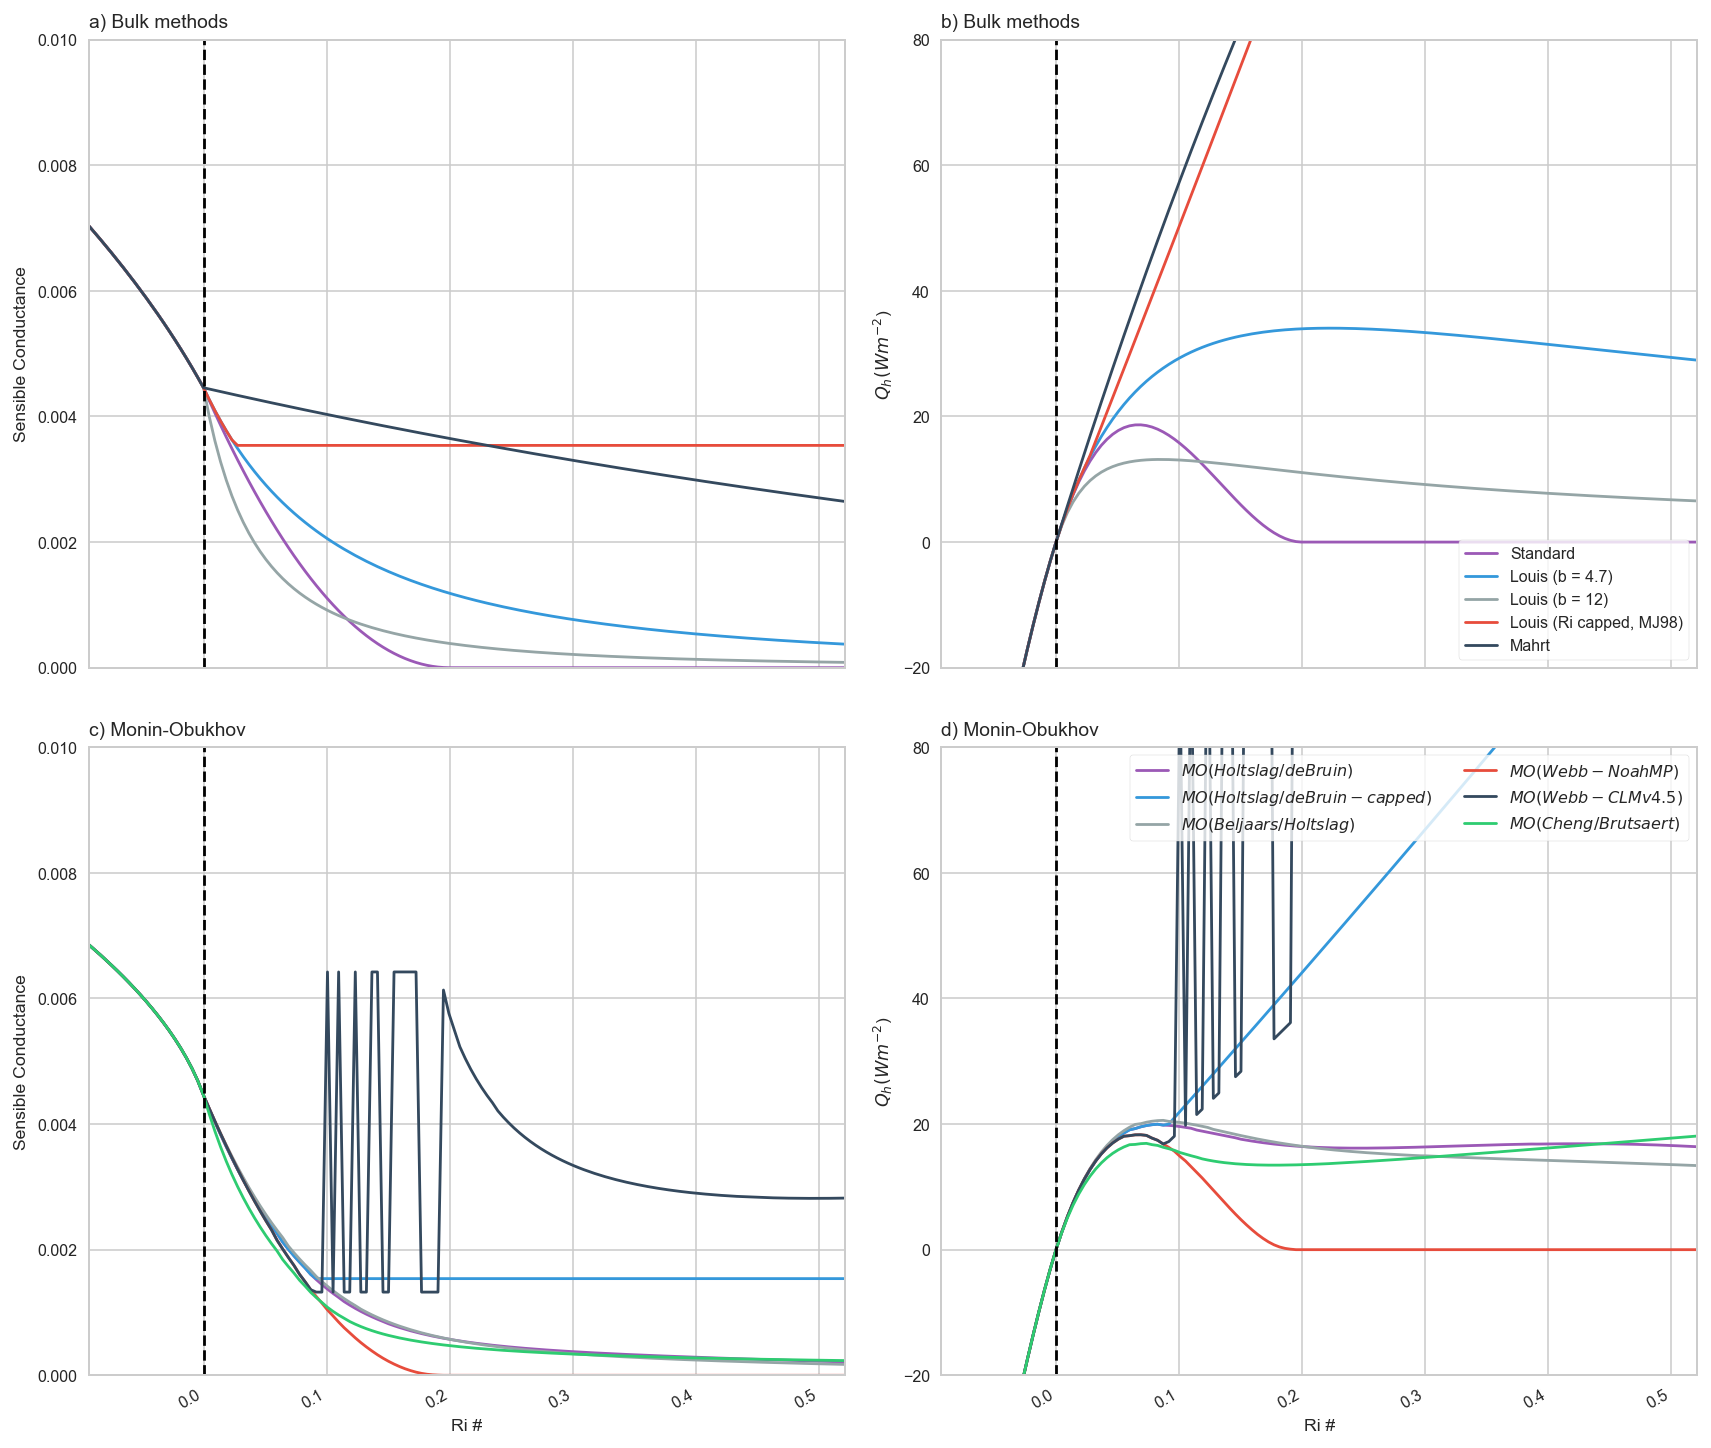

In [7]:
# Figure
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting parameters
Qmax = 80
Qmin = -20
RiMax = np.max(RiBulk)
RiMin = np.min(RiBulk)

# Bulk methods
for stab in stab_titles:
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    
    # a) Conductance
    ax = axes[0]
    ax.plot(RiBulk, conductance_sensible[stab] / windspd)#, color=colr[title])

    # b) Sensible Heat Flux
    ax = axes[1]
    ax.plot(RiBulk, sensible_heat[stab], label=stab)#, color=colr[title]
    
ax = axes[0]
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a) Bulk methods', loc='left')


ax = axes[1]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Bulk methods', loc='left')
lgd = ax.legend(loc='lower right', frameon=True)

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    # b) Conductance
    ax = axes[2]
    ax.plot(RiBulk, conductance_sensible[stab])#, color=colr[title])

    # c) Sensible Heat Flux
    ax = axes[3]
    ax.plot(RiBulk, sensible_heat[stab], label='$' + stab + '$')#, color=colr[title]
    

ax = axes[2]
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('c) Monin-Obukhov', loc='left')

ax = axes[3]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('d) Monin-Obukhov', loc='left')
lgd = ax.legend(loc='upper right', frameon=True, ncol=2)

fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dir_print)
fig.savefig('TF.OfflineTurb.idealized.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.OfflineTurb.idealized.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

Demonstrating the behavior of all turbpy methods. Top row is the bulk methods, bottom row is the Monin-Obukhov methods.

I find it somewhat interesting that the Mahrt and Louis with capping (from CROCUS) are pretty much identical. Effectively, Mahrt created a capping method through a physically justified mechanism. That's a point that is definitely worth mentioning!

### The CLM implementation of Webb

Why does it have that bizarre oscillatory behavior?

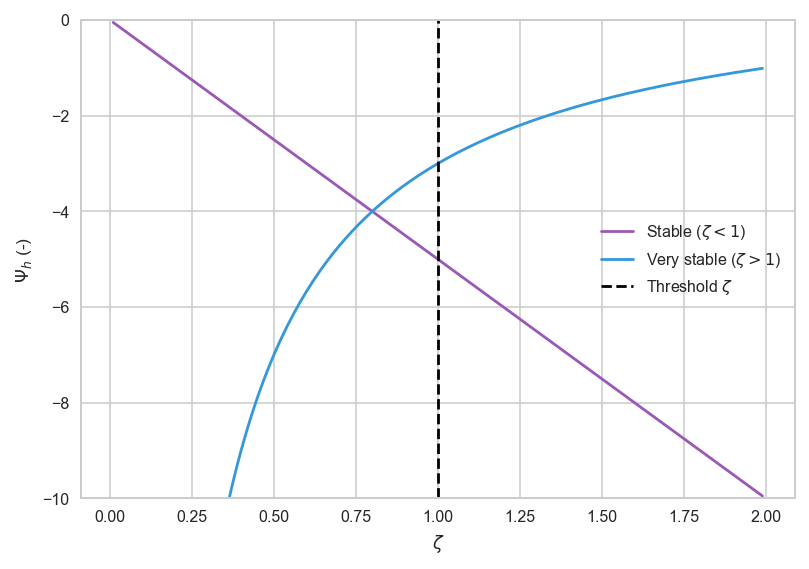

In [8]:
zeta = np.arange(0.01, 2, 0.01)

alpha = 5
Psi_stable = -alpha * zeta
Psi_very_stable = (1 - alpha + zeta) / zeta

fig, ax = plt.subplots(1, 1)
ax.plot(zeta, Psi_stable, label='Stable ($\zeta < 1$)')
ax.plot(zeta, Psi_very_stable, label='Very stable ($\zeta > 1$)')
ax.plot([1, 1], [-10, 0], 'k--', label='Threshold $\zeta$')
ax.set_ylabel('$\Psi_h$ (-)')
ax.set_xlabel('$\zeta$')
ax.set_ylim(-10, 0)
ax.legend()

The two stability corrections for the Webb implementation in CLMv4.5 do not converge at the threshold value of $\zeta = 1$. The cross over value instead comes at some $\zeta$ around 0.75. This explains the total nonsense coming out of that method. 

It should be noted that this is not what is actually inside CLMv4.5. What is inside is some bastardized version of multiple stability schemes, with none of the decisions documented. What is documented is the above solution.

From here on out I will not use the CLM method as it is distracting and not useful to analyze.

In [9]:
# Remove the CLM implementation from the rest of the iterations
stab_titles.remove('MO (Webb - CLMv4.5)')
stab_titles

['Standard',
 'Louis (b = 4.7)',
 'Louis (b = 12)',
 'Louis (Ri capped, MJ98)',
 'Mahrt',
 'MO (Holtslag/de Bruin)',
 'MO (Holtslag/de Bruin - capped)',
 'MO (Beljaars/Holtslag)',
 'MO (Webb - NoahMP)',
 'MO (Cheng/Brutsaert)']

## Importance of the z0 parameterization

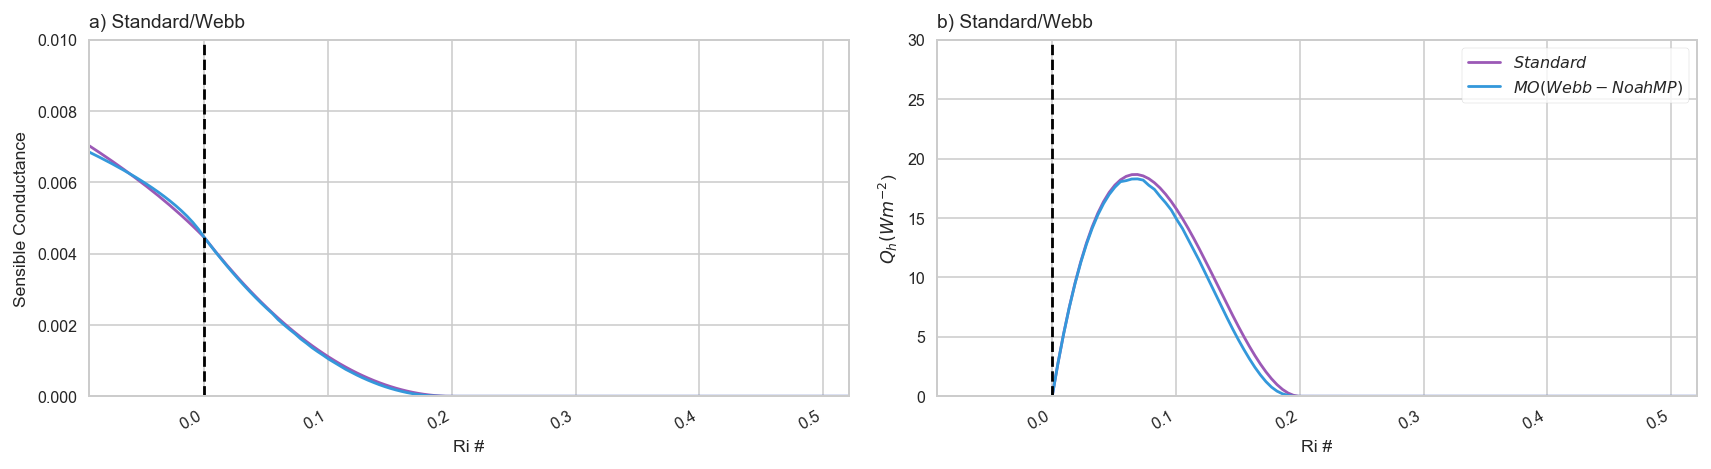

In [10]:
# Figure
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
axes = axes.flatten()

# Plotting parameters
Qmax = 30
Qmin = 0
RiMax = np.max(RiBulk)
RiMin = np.min(RiBulk)

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        if not stab_dict[stab]['stability_method'] == 'standard':
            continue
    elif 'webb' not in stab_dict[stab]['monin_obukhov']['gradient_function']:
        continue
    
    # b) Conductance
    ax = axes[0]
    if stab_dict[stab]['stability_method'] == 'standard':
        ax.plot(RiBulk, conductance_sensible[stab] / windspd)#, color=colr[title])
    else:
        ax.plot(RiBulk, conductance_sensible[stab])#, color=colr[title])

    # c) Sensible Heat Flux
    ax = axes[1]
    ax.plot(RiBulk, sensible_heat[stab], label='$' + stab + '$')#, color=colr[title]

ax = axes[0]
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a) Standard/Webb', loc='left')


ax = axes[1]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Standard/Webb', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)

fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dir_print)
fig.savefig('TF.OfflineTurb.idealized_loglinear.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.OfflineTurb.idealized_loglinear.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

Here is a comparison of the standard (bulk Richardson) and Webb (Monin-Obukhov) methods. Webb from NoahMP and the bulk Richardson "standard" method are qualitatively similar, which is good, because they are assumed to be equivalent. 

### Persistent differences between MO and bulk Ri approahces
A difference in magnitude can result from the z0 parameterization. With the Yang et al. (2008; WRF) and Andreas (1987; SNTHERM) parameterizations, the $z_0$ value ranges between abount right to small (0.005 and $10^{-6}$ respectively), which can lead to very small $Q_h$ values from the MO methods. However, many MO implementations consistently mention the need for enhancing the so-called thermal roughness length relative to the roughness length for momentum. 

My intution is that the z0 value I have chosen for these sites is appropriate. However, it is well known that bulk and similarity theory in stable boundary layers is broken due to very very steep inversions near the surface (within centimeters). I believe the reasons for this failing is most cleanly laid out in Sodemann and Foken (2005). This likely has some role in the necessity of enhancing z0 for heat relative to momentum.

## Effect of scaling $z_0$ on MO simulated $Q_h$

Below I test a constant $z_0$ = 0.05 (used in the simulations) and 0.005 (used by the bulk schemes), the Yang et al. (2008) parameterization (average values of 0.005 or so), and the Andreas (1987) method (average values around $10^{-6}$). 

In [11]:
# Initialzie dictionaries for containing output
## Stability parameters/methods

zo = {'Standard': 0.005,
      'MO (Webb, z0=0.005)': 0.005,
      'MO (Webb, z0=0.05)': 0.05,
      'MO (Webb, Yang08)': 0.005,
      'MO (Webb, Andreas)': 0.005,
     }

stab_titles = ['Standard',
               'MO (Webb, z0=0.05)',
               'MO (Webb, z0=0.005)',
               'MO (Webb, Yang08)',
               'MO (Webb, Andreas)'
              ]

stab_methods = {'Standard': 'standard',
                'MO (Webb, z0=0.05)': 'monin_obukhov',
                'MO (Webb, z0=0.005)': 'monin_obukhov',
                'MO (Webb, Yang08)': 'monin_obukhov',
                'MO (Webb, Andreas)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Webb, z0=0.05)': 'webb_noahmp',
                  'MO (Webb, z0=0.005)': 'webb_noahmp',
                  'MO (Webb, Yang08)': 'webb_noahmp',
                  'MO (Webb, Andreas)': 'webb_noahmp',
                 }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        stab_dict[st]['monin_obukhov']['roughness_function'] = ''
    
# Assing the roughness length function for the MO methods
stab_dict['MO (Webb, z0=0.005)']['monin_obukhov']['roughness_function'] = 'constant_z0'
stab_dict['MO (Webb, z0=0.05)']['monin_obukhov']['roughness_function'] = 'constant_z0'
stab_dict['MO (Webb, Yang08)']['monin_obukhov']['roughness_function'] = 'yang_08'
stab_dict['MO (Webb, Andreas)']['monin_obukhov']['roughness_function'] = 'andreas'

conductance_sensible_enh = {}
sensible_heat_enh = {}

for stab in stab_titles:
    conductance_sensible_enh[stab] = np.zeros_like(RiBulk)
    sensible_heat_enh[stab] = np.zeros_like(RiBulk)

# Calculate stability
for stab in stab_titles:
    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):

        # Offline Turbulence Package
        (conductance_sensible_enh[stab][n], _,
         sensible_heat_enh[stab][n], _,
         stab_output, p_test) = turbpy.turbFluxes(tair, airPressure,
                                                  vp, windspd, sfcTemp,
                                                  sfcVaporPress, snowDepth,
                                                  mHeight, param_dict=stab_dict[stab],
                                                  z0Ground=zo[stab])


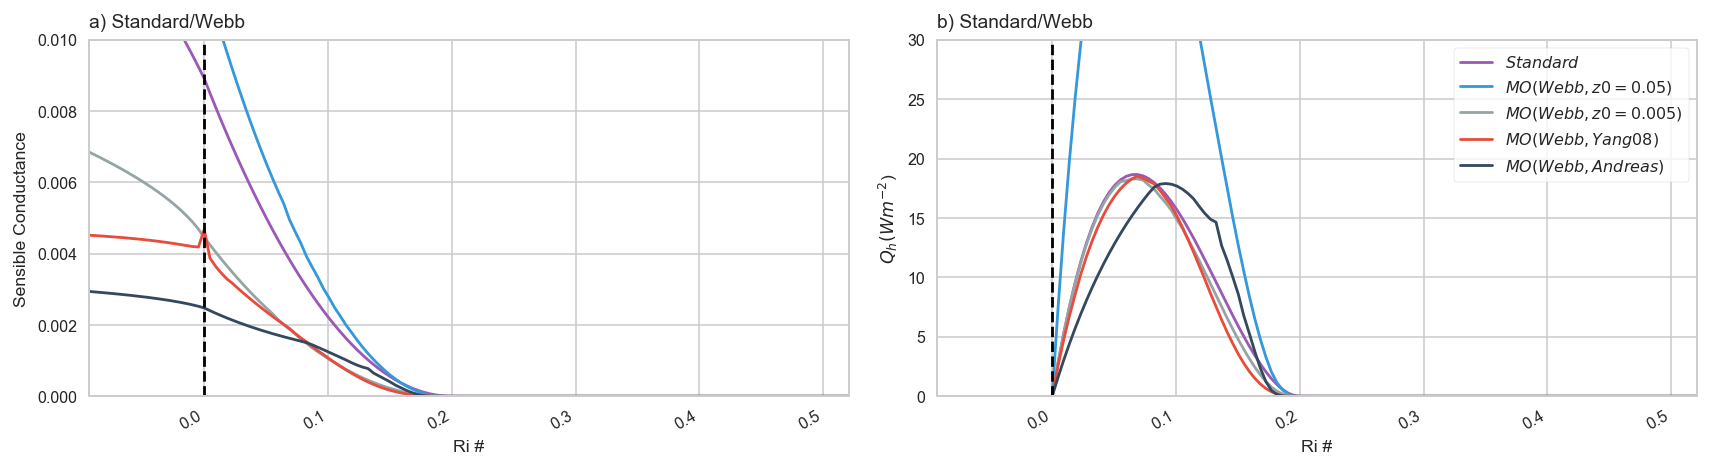

In [12]:
# Figure
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
axes = axes.flatten()

# Plotting parameters
Qmax = 30
Qmin = 0
RiMax = np.max(RiBulk)
RiMin = np.min(RiBulk)

# Monin Obukhov methods
for stab in stab_titles:
    
    # b) Conductance
    ax = axes[0]
    ax.plot(RiBulk, conductance_sensible_enh[stab])

    # c) Sensible Heat Flux
    ax = axes[1]
    ax.plot(RiBulk, sensible_heat_enh[stab], label='$' + stab + '$')

ax = axes[0]
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0, 0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a) Standard/Webb', loc='left')


ax = axes[1]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Standard/Webb', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)

fig.tight_layout()
fig.autofmt_xdate()

The Andreas parameterization (which is what I was using before) does not have the correct behavior. I will either use the Yang or constant z0 values.

## Qh as a function of wind speed

One of the single biggest results is the failure of the similarity theory methods. Boundary layer meteorologists tend to call the bulk methods "overly turbulent" or something similar. However, while the bulk methods can produce too much turbulence at higher wind speeds, the similarity theory methods produce very, very little turbulence, despite my best efforts to make anything happen otherwise.

I demonstrate this behavior below, keeping the temperature gradient the same and varying the wind speed.

In [13]:
## Met variables, varying wind speed
sfcTemp = 273
airTemp = 276
windspd = np.arange(0., 8, 0.25)
mHeight = 6.
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

## Model dictionary
stab_titles = ['Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'Mahrt',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              ]

stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'Mahrt': 'mahrt',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }
z0Ground = 0.005

## Simulate turbulence

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        stab_dict[st]['monin_obukhov']['roughness_function'] = 'constant_z0'
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}    


## Calculate stability

# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
sensible_heat = {}
zeta = {}
z0_arr = {}

for stab in stab_titles:
    stability_correction[stab] = np.zeros((RiBulk.size, 3))
    conductance_sensible[stab] = np.zeros((RiBulk.size, 3))
    sensible_heat[stab] = np.zeros((RiBulk.size, 3))
    zeta[stab] = np.zeros((RiBulk.size, 3))
    z0_arr[stab] = np.zeros((RiBulk.size, 3))

## Calculate stability
for stab in stab_titles:
    for nz, z0 in enumerate((0.05, 0.005, 0.0005)):
        for n, u in enumerate(windspd):


            # Offline Turbulence Package
            (conductance_sensible[stab][n, nz], _,
             sensible_heat[stab][n, nz], _,
             stab_output, p_test) = turbpy.turbFluxes(airTemp, airPressure,
                                                      airVaporPress, u, sfcTemp,
                                                      sfcVaporPress, snowDepth,
                                                      mHeight, param_dict=stab_dict[stab],
                                                      z0Ground=z0)

            # Unpack stability parameters dictionary
            if 'monin_obukhov' in stab_methods[stab]:
                z0_arr[stab][n, nz] = stab_output['z0']


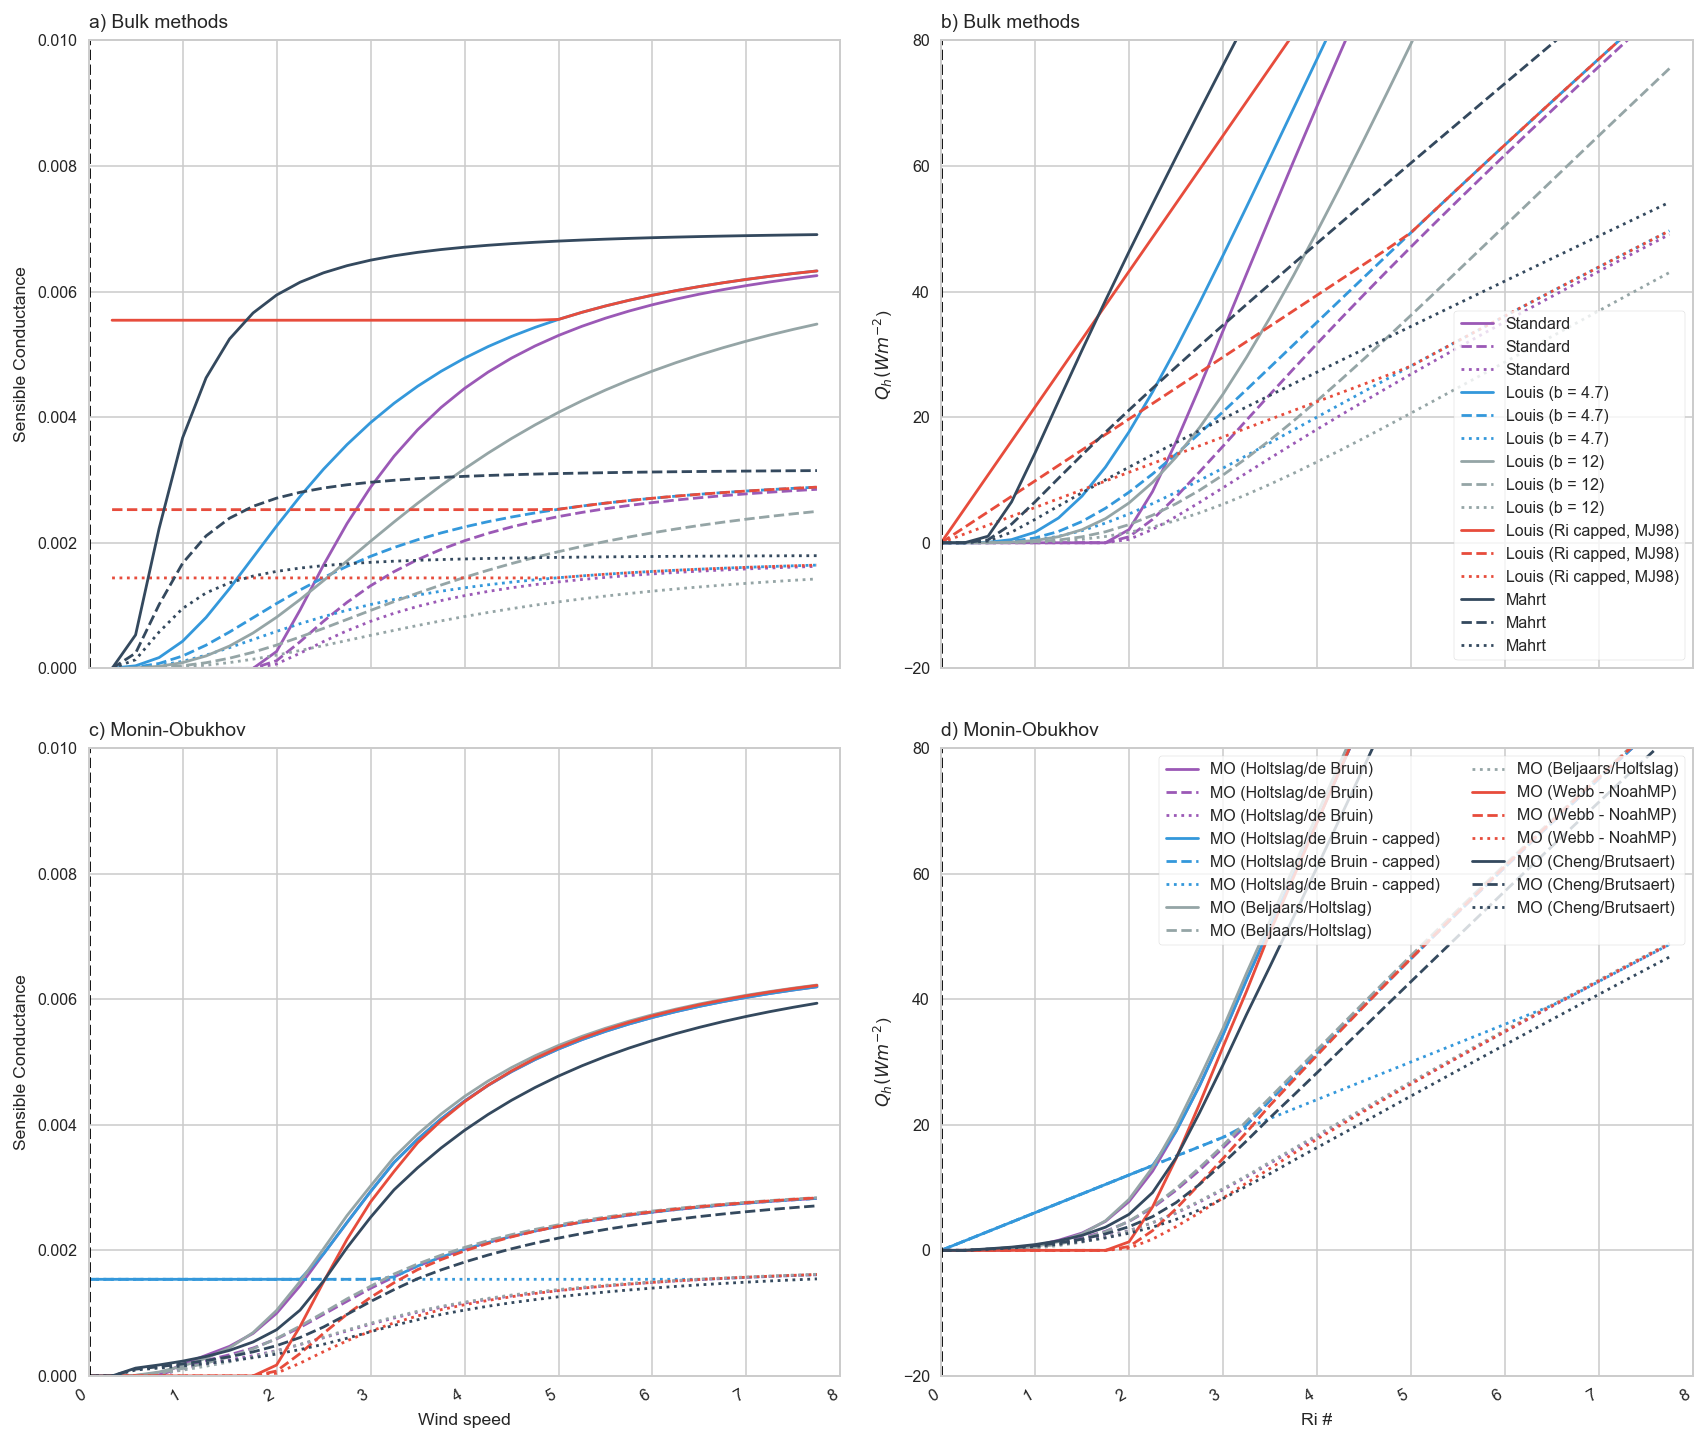

In [14]:
# Figure
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting parameters
Qmax = 80
Qmin = -20
RiMax = 8
RiMin = 0

ls = ['-', '--', ':']
bulk_stabs = [s for s in stab_titles if not stab_methods[s] == 'monin_obukhov'] 
most_stabs = [s for s in stab_titles if stab_methods[s] == 'monin_obukhov'] 

# Bulk methods
for nstab, stab in enumerate(bulk_stabs):
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    for nz, z in enumerate((0.05, 0.005, 0.0005)):
        # a) Conductance
        ax = axes[0]
        ax.plot(windspd, conductance_sensible[stab][:, nz] / windspd, ls=ls[nz], color=flatui[nstab])

        # b) Sensible Heat Flux
        ax = axes[1]
        ax.plot(windspd, sensible_heat[stab][:, nz], label=stab, ls=ls[nz], color=flatui[nstab])
    
ax = axes[0]
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a) Bulk methods', loc='left')


ax = axes[1]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Bulk methods', loc='left')
lgd = ax.legend(loc='lower right', frameon=True)

# Monin Obukhov methods
for nstab, stab in enumerate(most_stabs):
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    for nz, z in enumerate((0.05, 0.005, 0.0005)):
        # b) Conductance
        ax = axes[2]
        ax.plot(windspd, conductance_sensible[stab][:, nz], ls=ls[nz], color=flatui[nstab])

        # c) Sensible Heat Flux
        ax = axes[3]
        ax.plot(windspd, sensible_heat[stab][:, nz], label=stab, ls=ls[nz], color=flatui[nstab])
    

ax = axes[2]
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Wind speed')
ax.set_title('c) Monin-Obukhov', loc='left')

ax = axes[3]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('d) Monin-Obukhov', loc='left')
lgd = ax.legend(loc='upper right', frameon=True, ncol=2)

fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dir_print)
fig.savefig('TF.OfflineTurb_wind.idealized.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.OfflineTurb_wind.idealized.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

All similarity theory implementations assume that the stability correction, $\Psi$, goes to zero at the cross over point between stable and unstable conditions. From that assumption, the conductance becomes
$$
C_h = \frac{k^2}{\log{\frac{z}{z_0}}^2}
$$

for the values that I plugged in to make the graphs above, this gives a $C_h$ = 0.003 or so. We see that all of the methods converge to this value. Now I have good agreement between the bulk methods and the MO methods for Qh as a function of wind speed. Prior to this, I had a mistake in the MO code where I would return a windless conductance for the MO methods, but a Ch * wind for the bulk methods. That oversight led me to not include wind speed in the MO methods. Thank god it is fixed now.

# Testing some assumptions in the MO schemes.

## Testing the impact of using the full conductance calculation
- The defualt is to use the approximate conductance calculation. These cells use the full calculation (including the effect of z0/L on conductance) and then compare to the conductance calculation without this term included.
- The conclusion is that it doesn't really matter all that much.

In [15]:
# ## Calculate stability

# # Initialzie dictionaries for containing output
# conductance_sensible_ch = {}
# sensible_heat_ch = {}
# zeta_ch = {}
# z0_ch = {}

# for stab in stab_titles:
#     if 'monin_obukhov' in stab_methods[stab]:
#         conductance_sensible_ch[stab] = np.zeros_like(RiBulk)
#         sensible_heat_ch[stab] = np.zeros_like(RiBulk)
#         zeta_ch[stab] = np.zeros_like(RiBulk)
#         z0_ch[stab] = np.zeros_like(RiBulk)

# stab_dict_ch = copy.deepcopy(stab_dict)

# ## Calculate stability
# for stab in stab_titles:
#     if 'monin_obukhov' in stab_methods[stab]:
#         stab_dict_ch[stab]['monin_obukhov']['conductance_approx'] = 'full'
        
#         for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):

#             # Offline Turbulence Package
#             (conductance_sensible_ch[stab][n], _,
#              sensible_heat_ch[stab][n], _,
#              stab_output_ch, p_test) = turbpy.turbFluxes(tair, airPressure,
#                                                          vp, windspd, sfcTemp,
#                                                          sfcVaporPress, snowDepth,
#                                                          mHeight, param_dict=stab_dict_ch[stab],
#                                                          z0Ground=z0Ground)

#             zeta_ch[stab][n] = stab_output['zeta']
#             z0_ch[stab][n] = stab_output['z0']


In [16]:
# # Figure
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# axes = axes.flatten()

# # Plotting parameters
# Qmax = 50
# Qmin = -20
# RiMax = np.max(RiBulk)
# RiMin = np.min(RiBulk)

# # Andreas z0
# for stab in stab_titles:
#     if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
#         continue
    
#     # a) Conductance
#     ax = axes[0]
#     ax.plot(RiBulk, conductance_sensible_ch[stab])#, color=colr[title])

#     # b) Sensible Heat Flux
#     ax = axes[1]
#     ax.plot(RiBulk, sensible_heat_ch[stab], label=stab)#, color=colr[title]
    
# ax = axes[0]
# ax.plot([0, 0], [0., 0.1], 'k--')
# ax.set_ylim(0,0.01)
# ax.set_xlim(RiMin, RiMax)
# ax.set_ylabel('Sensible Conductance')
# ax.set_xlabel('Ri #')
# ax.set_title('a) Full conductance calculation', loc='left')


# ax = axes[1]
# ax.plot([0, 0], [Qmin, Qmax], 'k--')
# ax.set_ylim(Qmin, Qmax)
# ax.set_xlim(RiMin, RiMax)
# ax.set_xlabel('Ri #')
# ax.set_ylabel('$Q_h (Wm^{-2}$)')
# ax.set_title('b) Full conductance calculation', loc='left')
# lgd = ax.legend(loc='upper right', frameon=True)

# # Monin Obukhov methods
# for stab in stab_titles:
#     if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
#         continue
    
#     # b) Conductance
#     ax = axes[2]
#     ax.plot(RiBulk, conductance_sensible[stab])#, color=colr[title])

#     # c) Sensible Heat Flux
#     ax = axes[3]
#     ax.plot(RiBulk, sensible_heat[stab], label='$' + stab + '$')#, color=colr[title]
    

# ax = axes[2]
# ax.plot([0, 0], [0., 0.1], 'k--')
# ax.set_ylim(0,0.01)
# ax.set_xlim(RiMin, RiMax)
# ax.set_ylabel('Sensible Conductance')
# ax.set_xlabel('Ri #')
# ax.set_title('c) Constant z0', loc='left')

# ax = axes[3]
# ax.plot([0, 0], [Qmin, Qmax], 'k--')
# ax.set_ylim(Qmin, Qmax)
# ax.set_xlim(RiMin, RiMax)
# ax.set_xlabel('Ri #')
# ax.set_ylabel('$Q_h (Wm^{-2}$)')
# ax.set_title('d) Constant z0', loc='left')
# lgd = ax.legend(loc='upper right', frameon=True, ncol=2)

# fig.tight_layout()
# fig.autofmt_xdate()
# os.chdir(dir_print)
# fig.savefig('TF.OfflineTurb.idealized.chtest.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
# fig.savefig('TF.OfflineTurb.idealized.chtest.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Figure for the paper

In [17]:
sfcTemp = 265
airTemp = np.arange(260, 295, 0.25)
windspd = 2.
mHeight = 2.
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

stab_titles = ['Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              ]

axis_titles = {'Standard': 'log-linear',
               'Louis (b = 4.7)': 'Louis',
               'Louis (b = 12)': 'Louis (mod)',
               'Louis (Ri capped, MJ98)': 'Louis (capped)',
               'MO (Holtslag/de Bruin)': 'HD88',
               'MO (Holtslag/de Bruin - capped)': 'HD88 (capped)',
               'MO (Beljaars/Holtslag)': 'BH91',
               'MO (Webb - NoahMP)': 'Webb',
               'MO (Cheng/Brutsaert)': 'CB05',}

stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        stab_dict[st]['monin_obukhov']['roughness_function'] = 'constant_z0'
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}
        
z0Ground = 0.005

In [18]:
## Calculate stability

# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
sensible_heat = {}
zeta = {}
z0 = {}

for stab in stab_titles:
    stability_correction[stab] = np.zeros_like(RiBulk)
    conductance_sensible[stab] = np.zeros_like(RiBulk)
    sensible_heat[stab] = np.zeros_like(RiBulk)
    zeta[stab] = np.zeros_like(RiBulk)
    z0[stab] = np.zeros_like(RiBulk)

## Calculate stability
for stab in stab_titles:

    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):


        # Offline Turbulence Package
        (conductance_sensible[stab][n], _,
         sensible_heat[stab][n], _,
         stab_output, p_test) = turbpy.turbFluxes(tair, airPressure,
                                                  vp, windspd, sfcTemp,
                                                  sfcVaporPress, snowDepth,
                                                  mHeight, param_dict=stab_dict[stab],
                                                  z0Ground=z0Ground)
        
        # Unpack stability parameters dictionary
        if not 'monin_obukhov' in stab_methods[stab]:
            stability_correction[stab][n] = stab_output['stabilityCorrection']
        else:
            stability_correction[stab][n] = np.nan
            zeta[stab][n] = stab_output['zeta']
            z0[stab][n] = stab_output['z0']


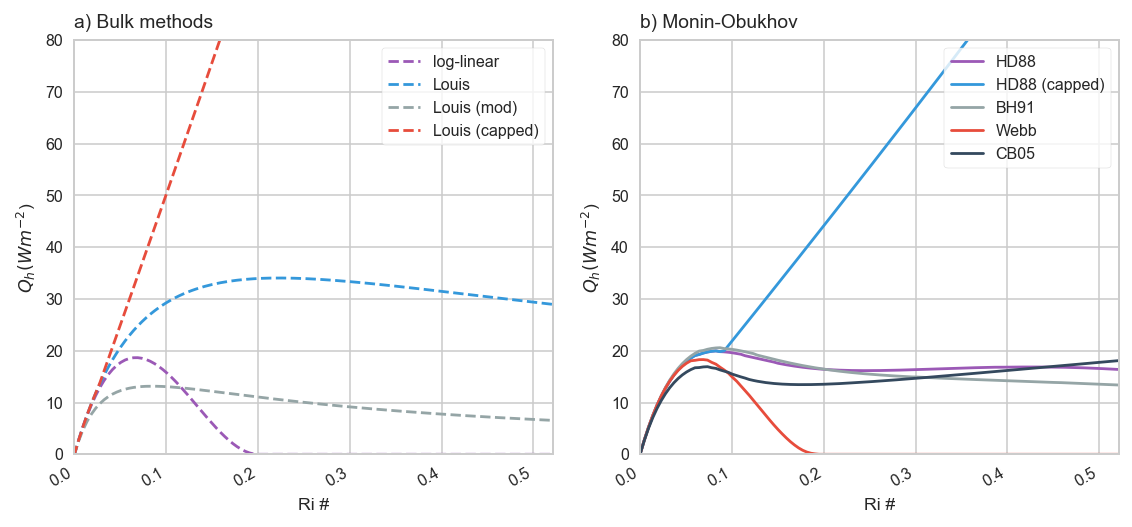

In [19]:
# Figure
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()

# Plotting parameters
Qmax = 80
Qmin = 0
RiMax = np.max(RiBulk)
RiMin = 0

# Bulk methods
for stab in stab_titles:
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    
    ax = axes[0]
    ax.plot(RiBulk, sensible_heat[stab], '--', label=axis_titles[stab])#, color=colr[title]
    
ax = axes[0]
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('a) Bulk methods', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    ax = axes[1]
    ax.plot(RiBulk, sensible_heat[stab], label=axis_titles[stab])#, color=colr[title]

ax = axes[1]
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Monin-Obukhov', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)

fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dir_print)
fig.savefig('TF.OfflineTurb.idealized.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.OfflineTurb.idealized.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [20]:
sfcTemp = 265
airTemp = np.arange(265, 275, 0.25)
windspd = np.arange(0.1, 9, 0.25)
mHeight = 2.
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

stab_titles = ['Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              ]

axis_titles = {'Standard': 'log-linear',
               'Louis (b = 4.7)': 'Louis',
               'Louis (b = 12)': 'Louis (mod)',
               'Louis (Ri capped, MJ98)': 'Louis (capped)',
               'MO (Holtslag/de Bruin)': 'HD88',
               'MO (Holtslag/de Bruin - capped)': 'HD88 (capped)',
               'MO (Beljaars/Holtslag)': 'BH91',
               'MO (Webb - NoahMP)': 'Webb',
               'MO (Cheng/Brutsaert)': 'CB05',}

stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'Mahrt': 'mahrt',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        stab_dict[st]['monin_obukhov']['roughness_function'] = 'constant_z0'
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}
        
z0Ground = [0.05, 0.005, 0.0005]

In [21]:
## Calculate stability

# # Initialzie dictionaries for containing output
conductance_sensible = {}
sensible_heat = {}

for stab in stab_titles:
    sensible_heat[stab] = np.zeros((airTemp.size, windspd.size, 3))

## Calculate stability
for stab in stab_titles:
    print(stab)
    for nz, z0 in enumerate(z0Ground):
        print(z0)
        for nt, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):
            for nu, u in enumerate(windspd):


                # Offline Turbulence Package
                (_, _,
                 sensible_heat[stab][nt, nu, nz], _,
                 stab_output, p_test) = turbpy.turbFluxes(tair, airPressure,
                                                          vp, u, sfcTemp,
                                                          sfcVaporPress, snowDepth,
                                                          mHeight, param_dict=stab_dict[stab],
                                                          z0Ground=z0)


Standard
0.05
0.005
0.0005
Louis (b = 4.7)
0.05
0.005
0.0005
Louis (b = 12)
0.05
0.005
0.0005
Louis (Ri capped, MJ98)
0.05
0.005
0.0005
MO (Holtslag/de Bruin)
0.05
0.005
0.0005
MO (Holtslag/de Bruin - capped)
0.05
0.005
0.0005
MO (Beljaars/Holtslag)
0.05
0.005
0.0005
MO (Webb - NoahMP)
0.05
0.005
0.0005
MO (Cheng/Brutsaert)
0.05
0.005
0.0005


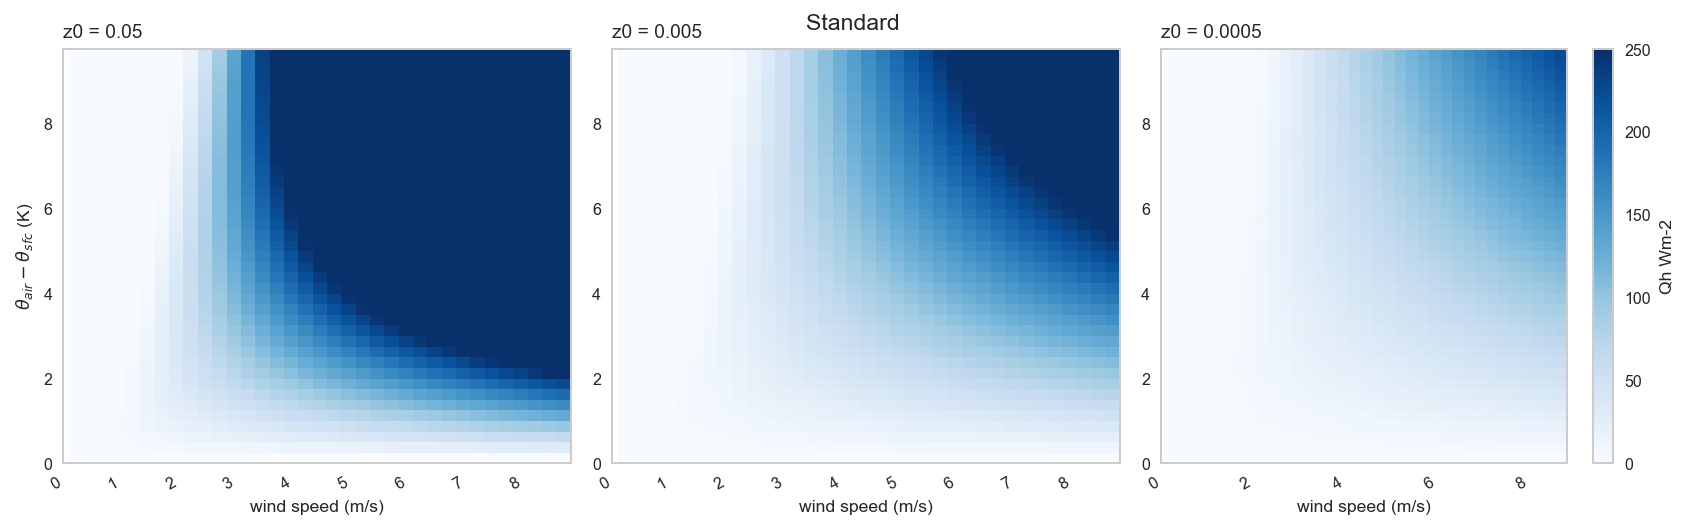

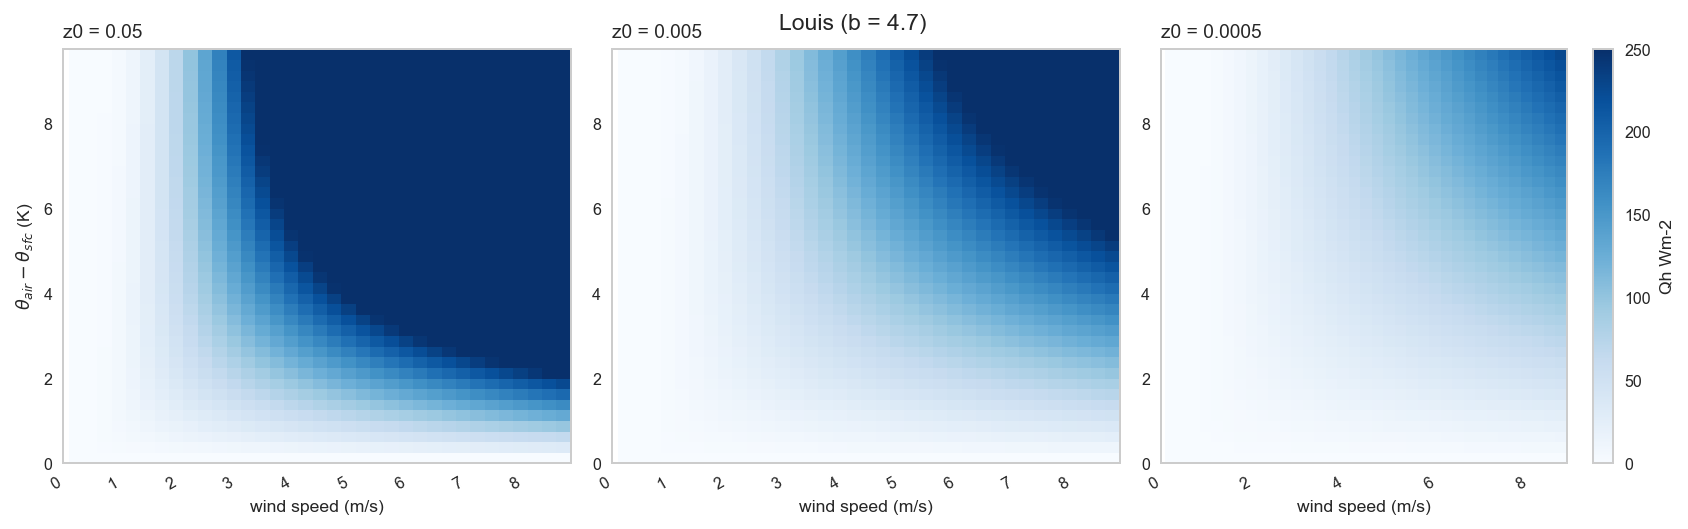

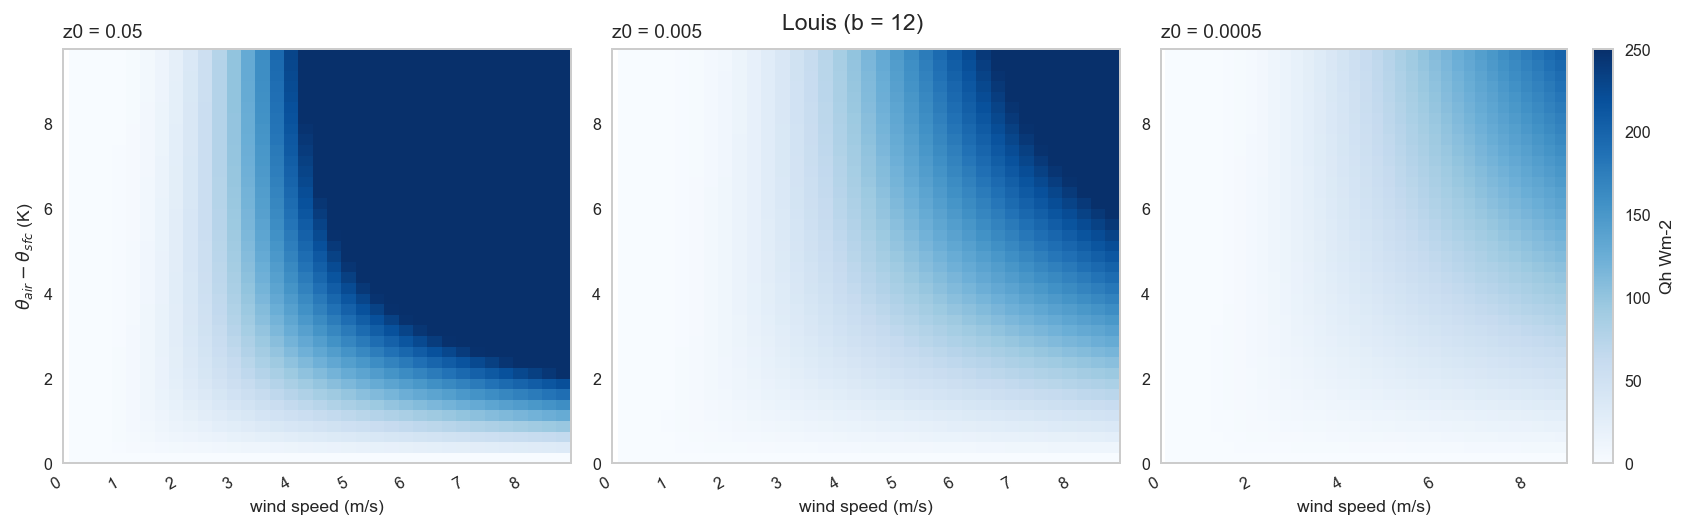

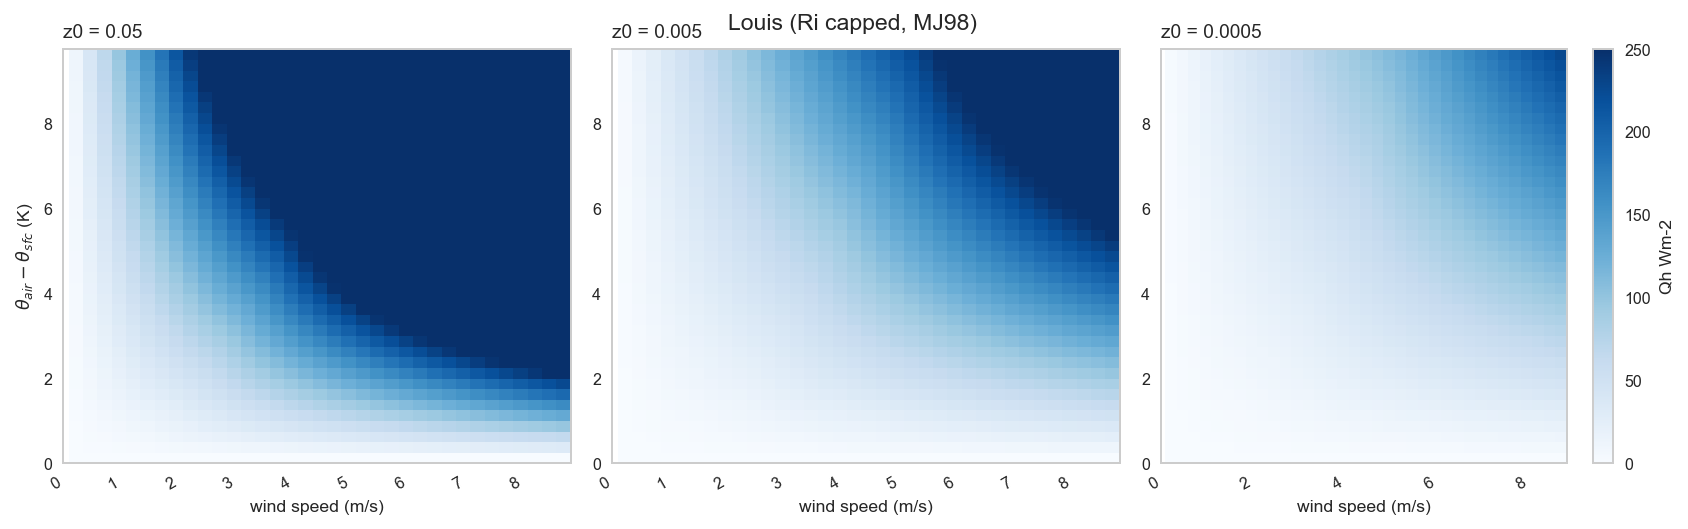

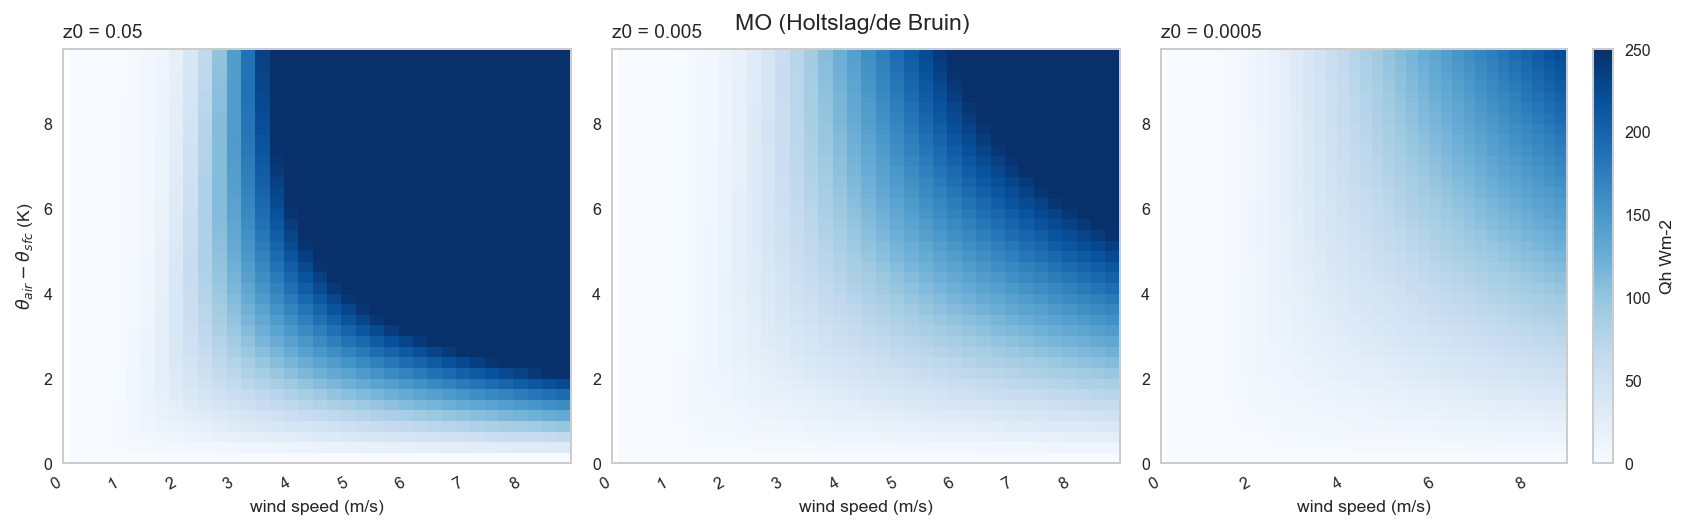

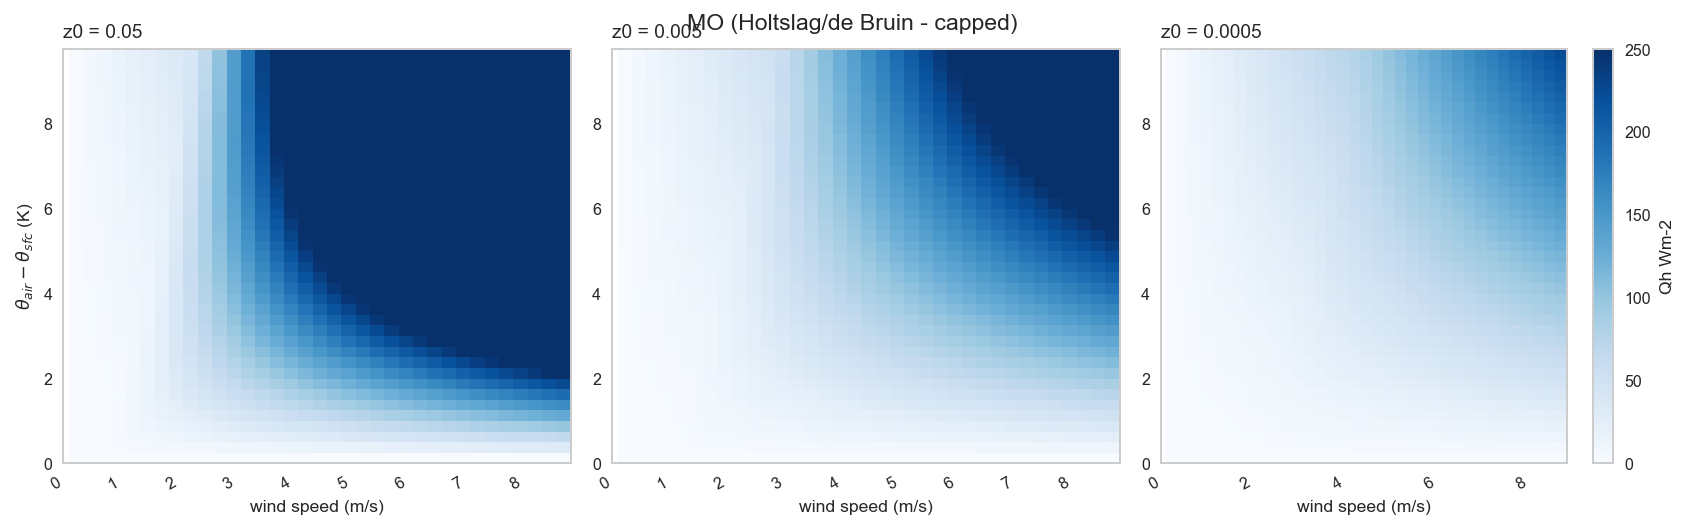

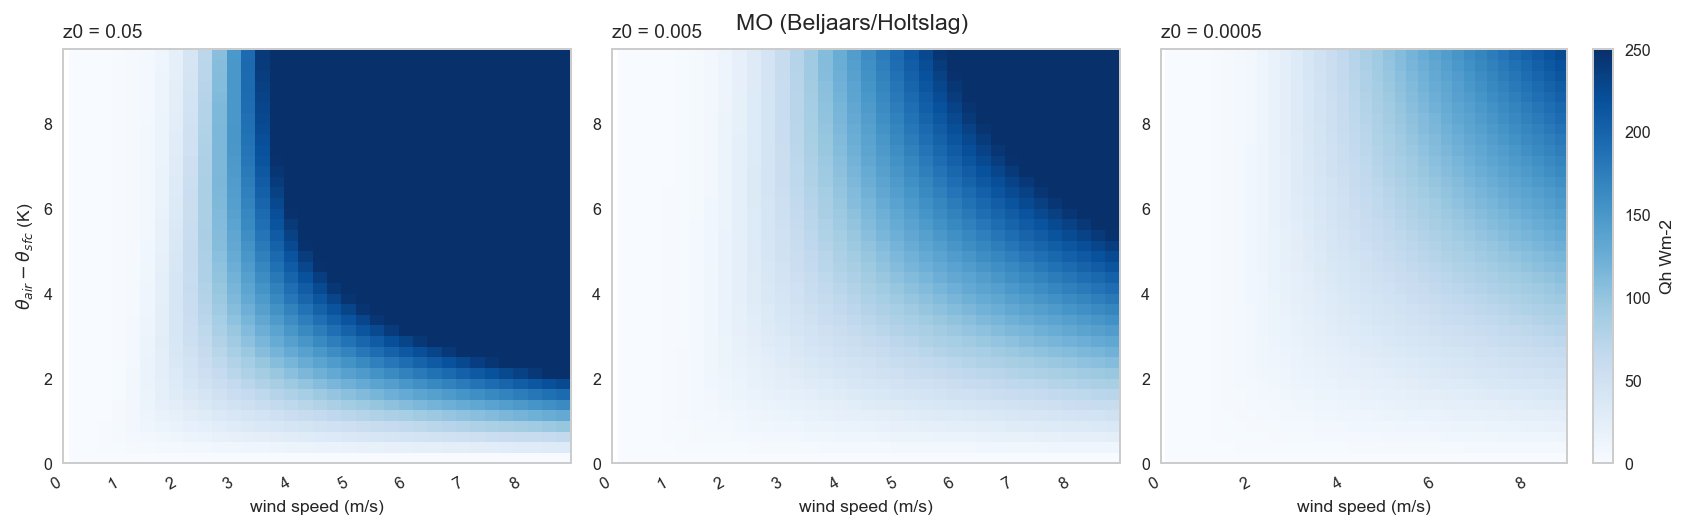

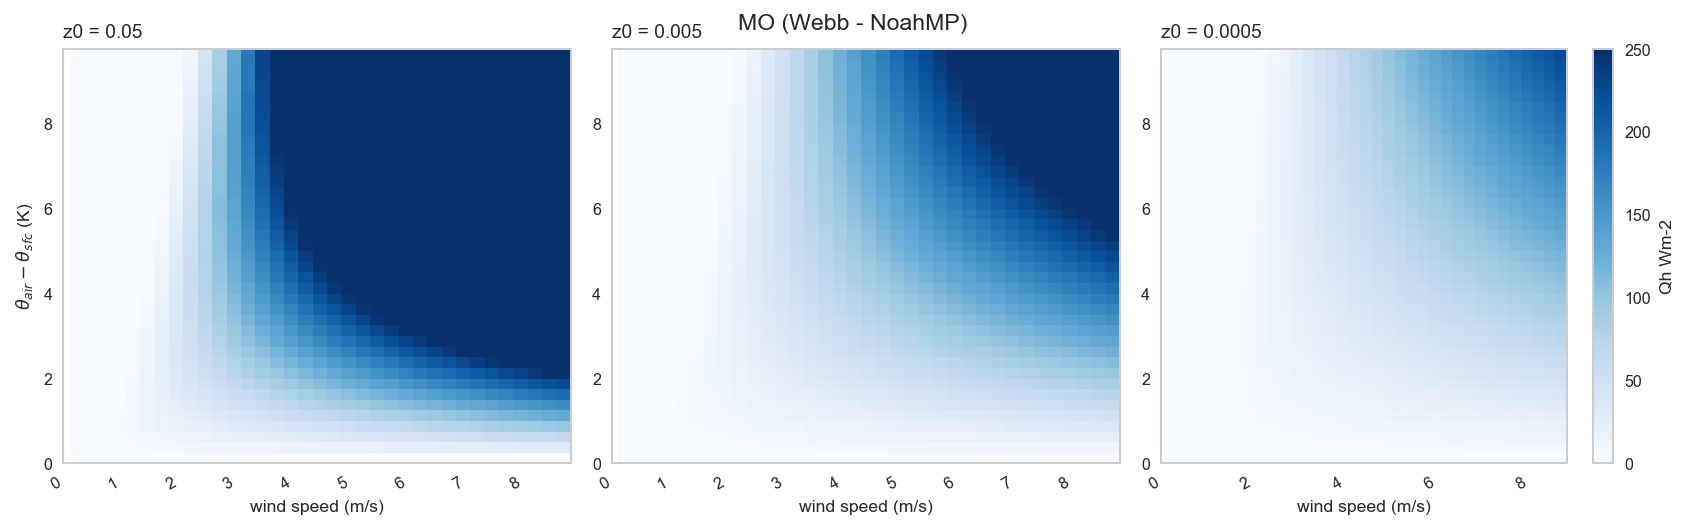

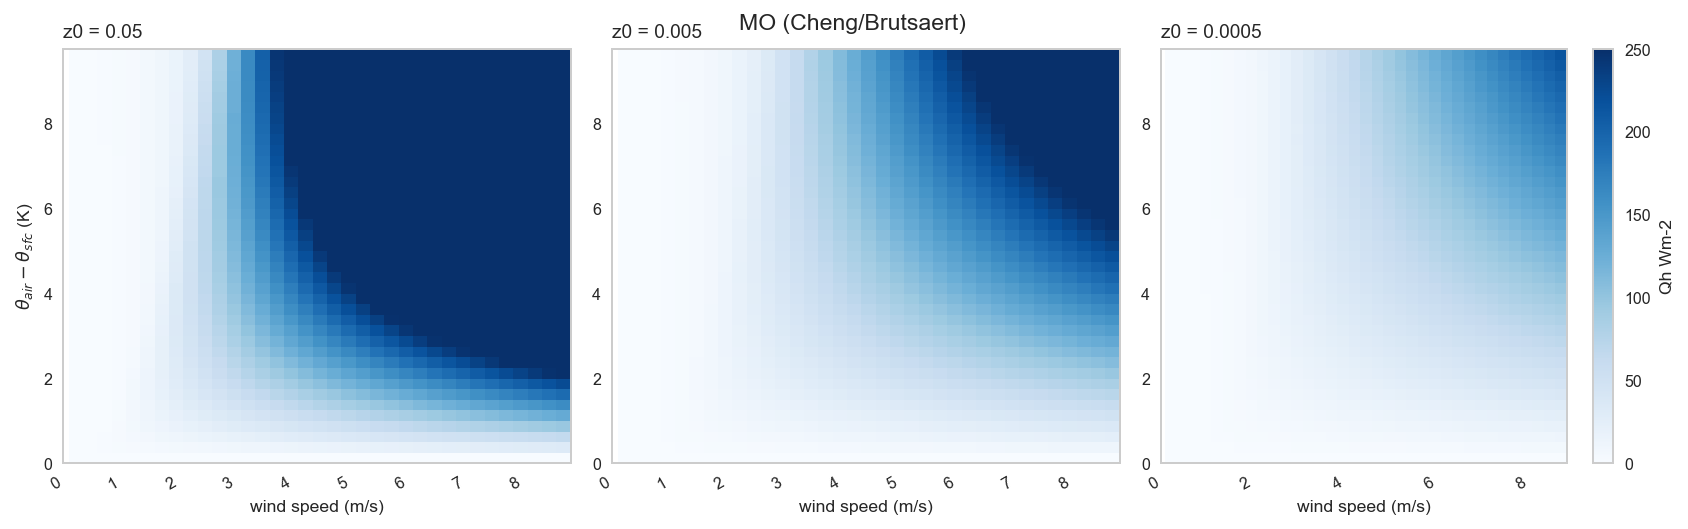

In [22]:
# Plotting parameters
Qmax = 250
Qmin = 0
xmax = np.max(windspd)
xmin = 0
ymax = np.max(airTemp - sfcTemp)
ymin = 0

# Bulk methods
for nstab, stab in enumerate(stab_titles):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes = axes.flatten()

    for nz, z in enumerate((0.05, 0.005, 0.0005)):
        ax = axes[nz]
        im = ax.pcolormesh(windspd, airTemp - sfcTemp, sensible_heat[stab][:, :, nz], cmap=cm.Blues, vmin=Qmin, vmax=Qmax)
    
        if ax.is_first_col():
            ax.set_ylabel(r'$\theta_{air} - \theta_{sfc}$ (K)')
        ax.set_xlabel('wind speed (m/s)')
        ax.set_title('z0 = ' + str(z), loc='left')
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(xmin, xmax)
    
    fig.suptitle(stab)
    cbar = fig.colorbar(im)
    cbar.set_label('Qh Wm-2')
    fig.tight_layout()
    fig.autofmt_xdate()
    
    os.chdir(dir_print)
#     fig.savefig('TF.OfflineTurb_wind.idealized.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


In [23]:
cm.

SyntaxError: invalid syntax (<ipython-input-23-bb47da0702c4>, line 1)